## ECG Anomaly Classification

author: **Khuong Vo**

In [ ]:
!pip install biosppy, joblib

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import packages
import glob
import random
from collections import OrderedDict
from biosppy.signals import ecg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.interpolate as interp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from joblib import Parallel, delayed


import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, Dropout
from keras.preprocessing import sequence
from keras.backend.tensorflow_backend import set_session
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

seed = 6546
random.seed(seed)
np.random.seed(seed)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

Using TensorFlow backend.


### Working on the preprocessed dataset

There are 4 types of anomalies: Control, High P Amplitude, SA and ST.

All data under 1000 Hz sampling frequency.

In [3]:
con_dir = 'cleaned_data/control'
highp_dir = 'cleaned_data/high p wave'
sa_dir = 'cleaned_data/sinoatrial arrest'
st_dir = 'PROCESSED ECG database/processedST'

sampling_freq = 1000

In [4]:
def chunks(l, n):
    """Return successive n-sized chunks from l."""
    chunked_list = []
    for i in range(0, len(l), n):
        sublist = l[i:i + n]
        if len(sublist) == n:
            chunked_list.append(l[i:i + n])
    return chunked_list

In [5]:
def get_len_sublists(alist, level=1):
        if level == 1:
            return [len(sublist) for sublist in alist]
        elif level == 2:
            lens = []
            for inlist in alist:
                lens.extend(get_len_sublists(inlist))
            return lens

In [6]:
def select_random(alist):
    aux = list(alist)
    np.random.shuffle(aux)
    return aux[0]

Original signals whose lengths are greater than 5k data points (5 seconds of data recorded) are split into multiple samples of the same length of 5k if possible.

In [7]:
def read_signals(adir, all_files=False):
    # If a signal sequence is too long, split it into sublists
    standard_size = 5000 # 5 seconds
    if all_files:
        files = sorted(glob.glob(adir + '/*.csv'))
    else:
        files = sorted(glob.glob(adir + '/_*.csv'))

    signals = [pd.read_csv(fi, header=None)[0].values for fi in files]
    standard_signals = [signal for signal in signals if len(signal) < standard_size]
    oversized_signals = [signal for signal in signals if len(signal) >= standard_size]
    for signal in oversized_signals:
        standard_signals.extend(chunks(signal, standard_size))
    return standard_signals

con_signals = read_signals(con_dir, all_files=True)
highp_signals = read_signals(highp_dir, all_files=True)
sa_signals = read_signals(sa_dir, all_files=True)
st_signals = read_signals(st_dir)

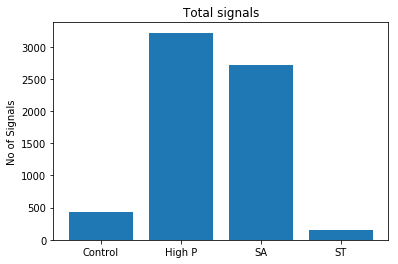

In [8]:
anomalies = ['Control', 'High P', 'SA', 'ST']
y_pos = np.arange(len(anomalies))
lengths = [len(con_signals), len(highp_signals), len(sa_signals), len(st_signals)]

plt.bar(y_pos, lengths, align='center')
plt.xticks(y_pos, anomalies)
plt.ylabel('No of Signals')
plt.title('Total signals')
plt.show()

In [9]:
plt.rcParams['figure.figsize'] = [15, 7]

#### Plot a Control ECG Singal

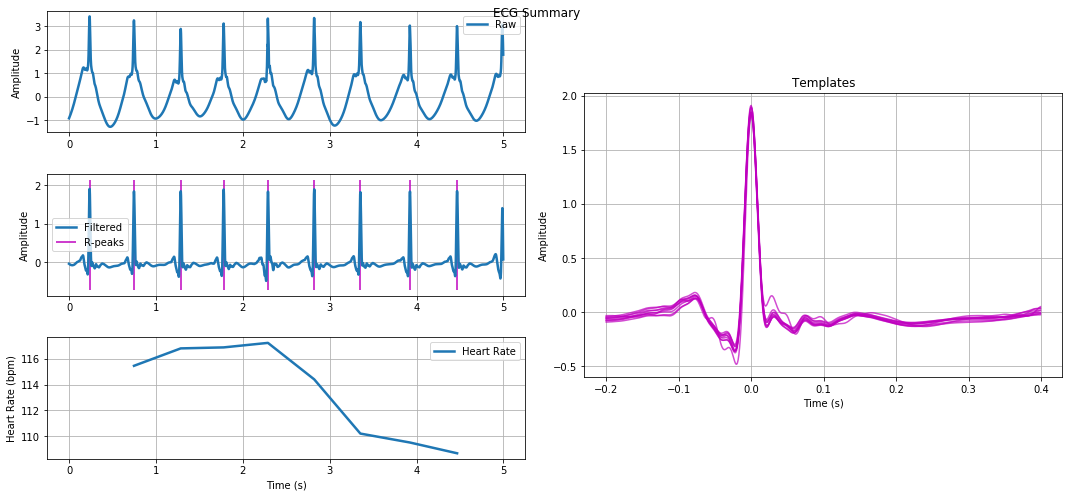

In [10]:
out_a_con = ecg.ecg(signal=select_random(con_signals), sampling_rate=sampling_freq, show=True)

#### Plot a High P Amplitude ECG Singal

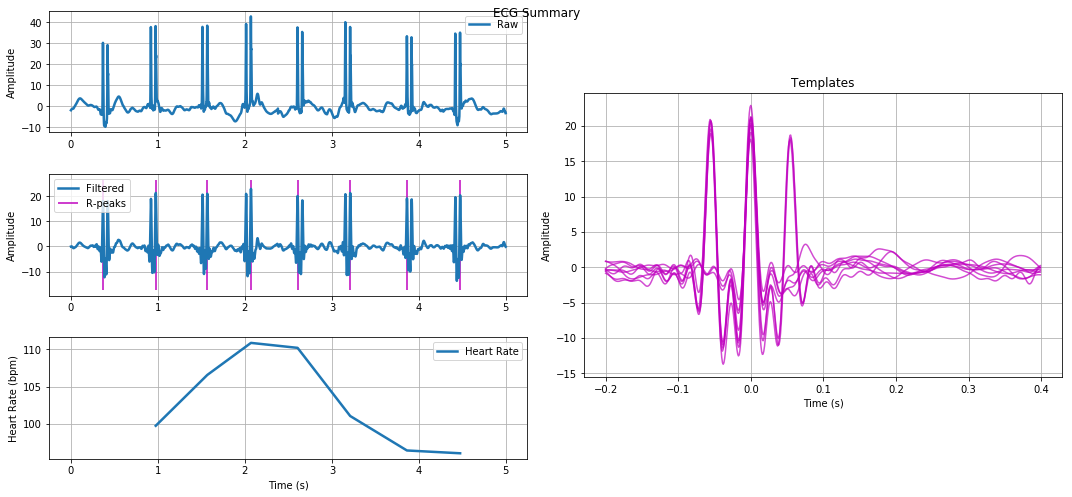

In [11]:
out_a_highp = ecg.ecg(signal=select_random(highp_signals), sampling_rate=sampling_freq, show=True)

#### Plot a SA ECG Singal

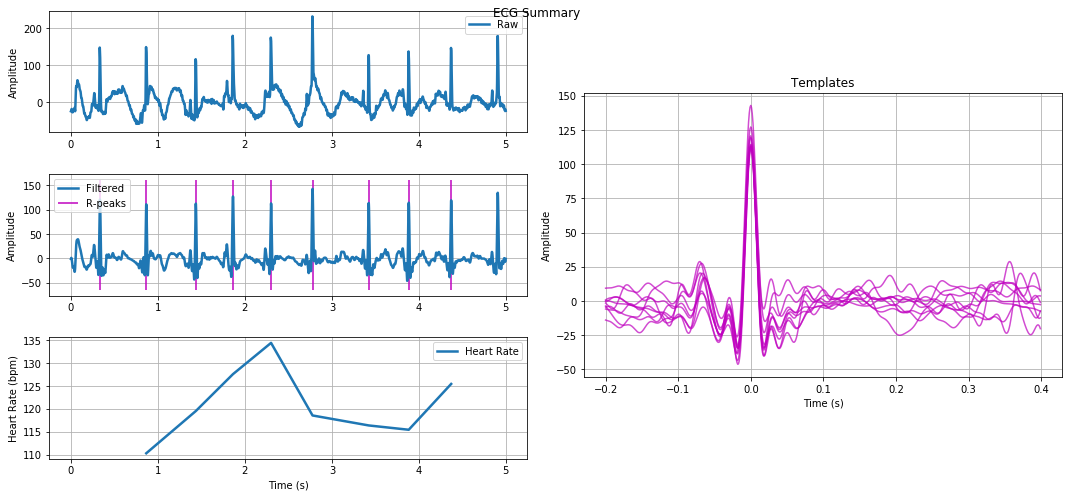

In [12]:
out_a_sa = ecg.ecg(signal=select_random(sa_signals), sampling_rate=sampling_freq, show=True)

#### Plot a ST ECG Singal

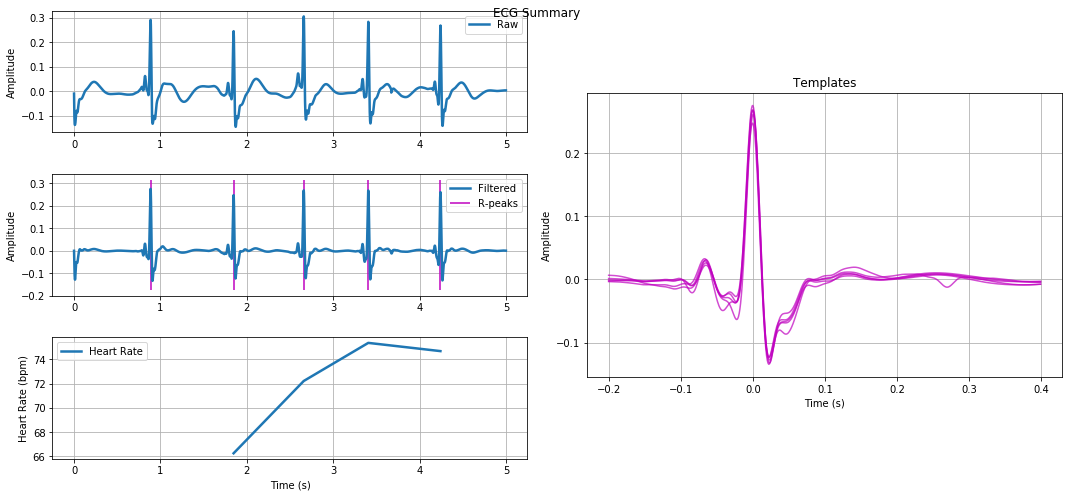

In [13]:
out_a_st = ecg.ecg(signal=select_random(st_signals), sampling_rate=sampling_freq, show=True)

In [14]:
plt.rcParams['figure.figsize'] = [6, 4]

### Scale signal amplitudes

In [15]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()
def scale_singals(signals):
    return [scaler.fit_transform(signal.reshape(-1, 1)).flatten() for signal in signals]

con_signals_scaled = scale_singals(con_signals)
highp_signals_scaled = scale_singals(highp_signals)
sa_signals_scaled = scale_singals(sa_signals)
st_signals_scaled = scale_singals(st_signals)

### Extract R-R intervals

In [16]:
def cal_r_peaks(signal, sampling_rate=sampling_freq):
    rpeaks, = ecg.hamilton_segmenter(signal=signal, sampling_rate=sampling_rate)
    rpeaks, = ecg.correct_rpeaks(signal=signal, rpeaks=rpeaks, sampling_rate=sampling_rate, tol=0.05)
    templates, rpeaks = ecg.extract_heartbeats(signal=signal, rpeaks=rpeaks, sampling_rate=sampling_rate, before=0.2, after=0.4)
    return rpeaks

def get_r_peaks(signals):
    return Parallel(n_jobs=6)(delayed(cal_r_peaks)(signal) for signal in signals)

In [17]:
con_r_peaks = get_r_peaks(con_signals_scaled)
highp_r_peaks = get_r_peaks(highp_signals_scaled)
sa_r_peaks = get_r_peaks(sa_signals_scaled)
st_r_peaks = get_r_peaks(st_signals_scaled)

In [18]:
def split_list(alist, indices):
    splitted_list = []
    for start, end in zip(indices, indices[1:]):
        sublist = alist[start:end+1]
        splitted_list.append(sublist)
    return splitted_list

def extract_rr_intervals(signals, r_peaks):
    rr_itvs = []
    for idx, signal in enumerate(signals):
        if r_peaks[idx] is None:
            continue
        rr_itvs.append(split_list(signal, r_peaks[idx].tolist()))
    return rr_itvs

In [19]:
con_rr_itvs = extract_rr_intervals(con_signals_scaled, con_r_peaks)
highp_rr_itvs = extract_rr_intervals(highp_signals_scaled, highp_r_peaks)
sa_rr_itvs = extract_rr_intervals(sa_signals_scaled, sa_r_peaks)
st_rr_itvs = extract_rr_intervals(st_signals_scaled, st_r_peaks)

In [20]:
plt.rcParams['figure.figsize'] = [6, 4]
def plot_rr_intervals(rr_intervals, anomaly):
    for rr in rr_intervals[1:-1]:
        plt.plot(rr)
    plt.title(anomaly)
    plt.show()

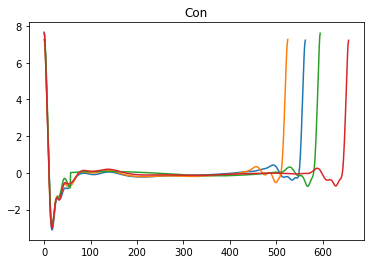

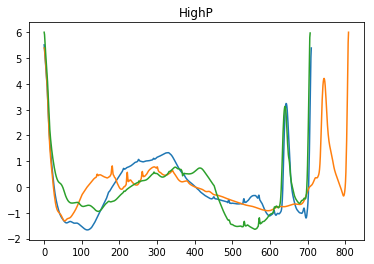

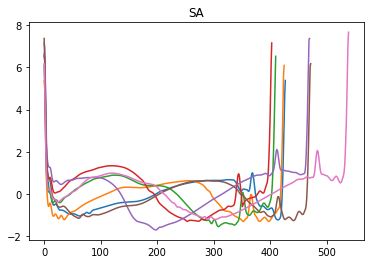

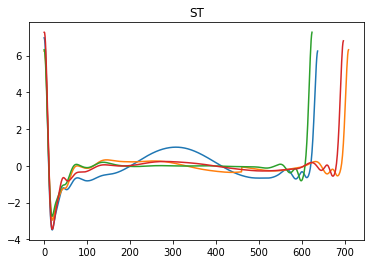

In [21]:
plot_rr_intervals(select_random(con_rr_itvs), 'Con')
plot_rr_intervals(select_random(highp_rr_itvs), 'HighP')
plot_rr_intervals(select_random(sa_rr_itvs), 'SA')
plot_rr_intervals(select_random(st_rr_itvs), 'ST')

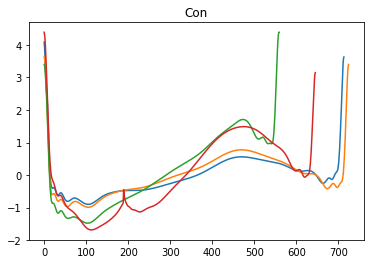

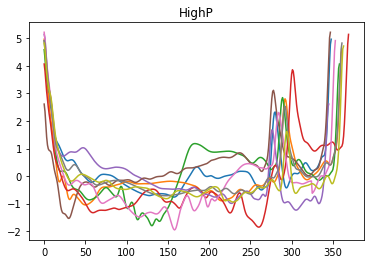

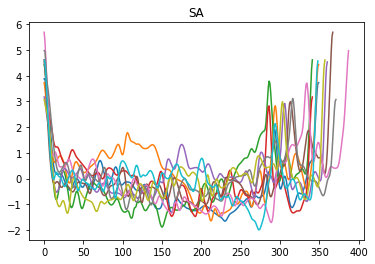

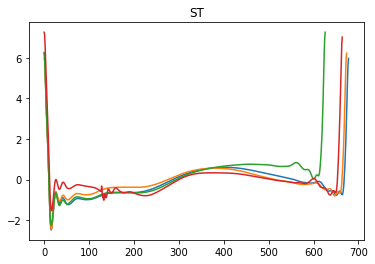

In [22]:
plot_rr_intervals(select_random(con_rr_itvs), 'Con')
plot_rr_intervals(select_random(highp_rr_itvs), 'HighP')
plot_rr_intervals(select_random(sa_rr_itvs), 'SA')
plot_rr_intervals(select_random(st_rr_itvs), 'ST')

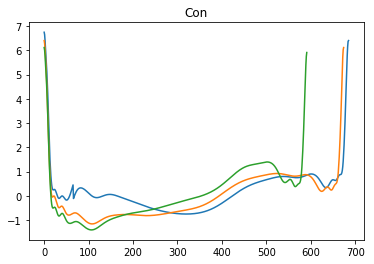

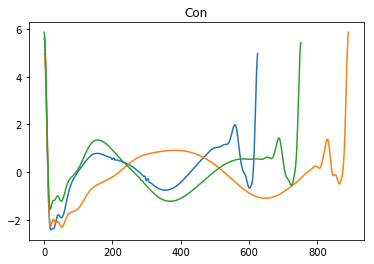

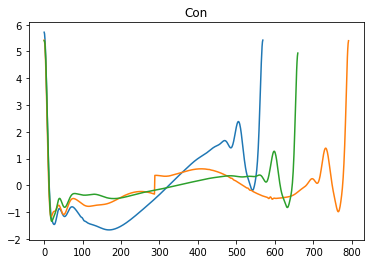

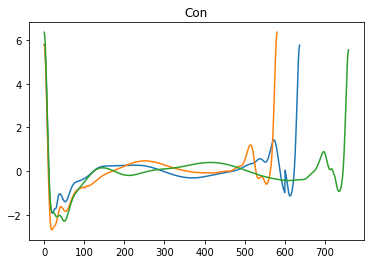

In [23]:
plot_rr_intervals(select_random(con_rr_itvs), 'Con')
plot_rr_intervals(select_random(con_rr_itvs), 'Con')
plot_rr_intervals(select_random(con_rr_itvs), 'Con')
plot_rr_intervals(select_random(con_rr_itvs), 'Con')

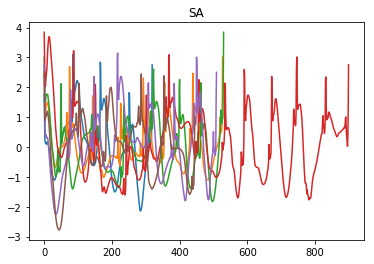

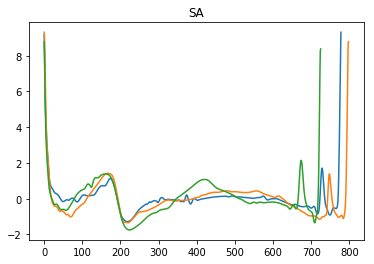

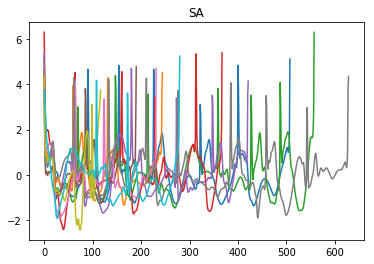

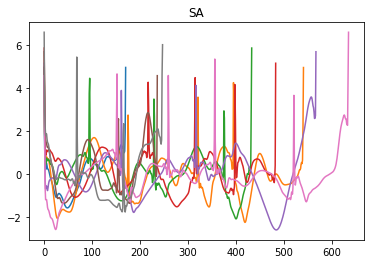

In [24]:
plot_rr_intervals(select_random(sa_rr_itvs), 'SA')
plot_rr_intervals(select_random(sa_rr_itvs), 'SA')
plot_rr_intervals(select_random(sa_rr_itvs), 'SA')
plot_rr_intervals(select_random(sa_rr_itvs), 'SA')

### R-R intervals are normalized to a specific length

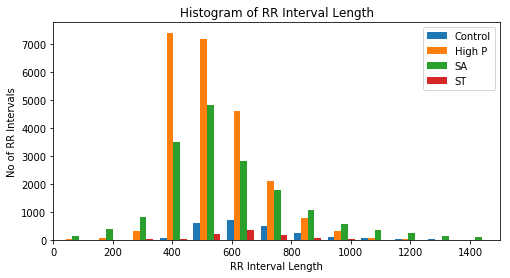

In [25]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.hist([get_len_sublists(con_rr_itvs, level=2), get_len_sublists(highp_rr_itvs, level=2), \
          get_len_sublists(sa_rr_itvs, level=2), get_len_sublists(st_rr_itvs, level=2)], 30, label=anomalies)
plt.legend(loc='upper right')
plt.xlabel('RR Interval Length')
plt.ylabel('No of RR Intervals')
plt.title('Histogram of RR Interval Length')
plt.xlim(0, 1500)
plt.show()

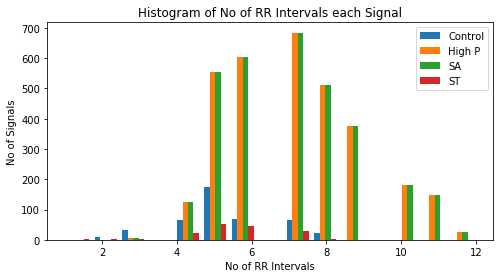

In [26]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.hist([get_len_sublists(con_rr_itvs), get_len_sublists(highp_rr_itvs), \
          get_len_sublists(highp_rr_itvs), get_len_sublists(st_rr_itvs)], 15, label=anomalies)
plt.legend(loc='upper right')
plt.xlabel('No of RR Intervals')
plt.ylabel('No of Signals')
plt.title('Histogram of No of RR Intervals each Signal')
plt.show()

In [27]:
rr_normalized_size = 1000
max_rr_intervals = 12

def linear_interpolation(rr_interval):
    rr_interp = interp.interp1d(np.arange(rr_interval.size), rr_interval)
    return rr_interp(np.linspace(0, rr_interval.size-1, rr_normalized_size))

def pre_pad_sequence(sequence):
    max_length = max_rr_intervals
    seq_length = sequence.shape[0]
    if seq_length == max_length:
        return sequence
    elif seq_length < max_length:
        dim = max_length - seq_length
        zeros_seq  = np.zeros((max_length - seq_length, rr_normalized_size))
        return np.concatenate([zeros_seq, sequence])
    else:
        return sequence[seq_length - max_length:]
        
def normalize_rr_intervals(signal_rr_intervals):
    signal_rr_itvs_normed = []
    for signal in signal_rr_intervals:
        rr_itvs_normed = []
        if len(signal) == 0:
            continue
        for rr in signal:
            rr_itvs_normed.append(linear_interpolation(rr))
        rr_itvs_normed_padded = pre_pad_sequence(np.array(rr_itvs_normed))
        signal_rr_itvs_normed.append(np.array(rr_itvs_normed_padded))
    return np.array(signal_rr_itvs_normed)

In [28]:
con_rr_itvs_normed = normalize_rr_intervals(con_rr_itvs)
highp_rr_itvs_normed = normalize_rr_intervals(highp_rr_itvs)
sa_rr_itvs_normed = normalize_rr_intervals(sa_rr_itvs)
st_rr_itvs_normed = normalize_rr_intervals(st_rr_itvs)

### R-R Interval Dimension Reduction with Autoencoder

In [29]:
X = np.concatenate([con_rr_itvs_normed, highp_rr_itvs_normed, sa_rr_itvs_normed, st_rr_itvs_normed])
y = np.concatenate([[[1, 0, 0, 0]] * len(con_rr_itvs_normed), \
                    [[0, 1, 0, 0]] * len(highp_rr_itvs_normed), \
                    [[0, 0, 1, 0]] * len(sa_rr_itvs_normed), \
                    [[0, 0, 0, 1]] * len(st_rr_itvs_normed)])
X, y = shuffle(X, y, random_state=seed)

In [30]:
#Split train, evaluation, and test sets
eval_split_pos = int(len(y) * .7)
test_split_pos = int(len(y) * .8)
X_train, y_train = X[:eval_split_pos], y[:eval_split_pos]
print('X_train.shape', X_train.shape)
X_eval, y_eval = X[eval_split_pos:test_split_pos], y[eval_split_pos:test_split_pos]
print('X_eval.shape', X_eval.shape)
X_test, y_test = X[test_split_pos:], y[test_split_pos:]
print('X_test.shape', X_test.shape)

# Reshape rr sequences into unordered rr intervals and remove zero padded rr rows
X_train_AE = X_train.reshape(-1, rr_normalized_size)
print('X_train.reshape', X_train_AE.shape)
all_zeros_rows_train = (X_train_AE==0).all(1)
X_train_AE = X_train_AE[~all_zeros_rows_train]
print('X_train_AE.shape', X_train_AE.shape)

X_eval_AE = X_eval.reshape(-1, rr_normalized_size)
print('X_eval.reshape', X_eval_AE.shape)
all_zeros_rows_eval = (X_eval_AE==0).all(1)
X_eval_AE = X_eval_AE[~all_zeros_rows_eval]
print('X_eval_AE.shape', X_eval_AE.shape)

X_test_AE = X_test.reshape(-1, rr_normalized_size)
print('X_test.reshape', X_test_AE.shape)
all_zeros_rows_test = (X_test_AE==0).all(1)
X_test_AE = X_test_AE[~all_zeros_rows_test]
print('X_test_AE.shape', X_test_AE.shape)

('X_train.shape', (4567, 12, 1000))
('X_eval.shape', (653, 12, 1000))
('X_test.shape', (1305, 12, 1000))
('X_train.reshape', (54804, 1000))
('X_train_AE.shape', (29968, 1000))
('X_eval.reshape', (7836, 1000))
('X_eval_AE.shape', (4286, 1000))
('X_test.reshape', (15660, 1000))
('X_test_AE.shape', (8727, 1000))


In [31]:
encoding_dim = 500
#Create 2-layer AE
input_rr = Input(shape=(rr_normalized_size,))
encoded = Dense(1024, activation='relu')(input_rr)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(1024, activation='relu')(encoded)
decoded = Dense(rr_normalized_size)(encoded)

autoencoder = Model(input_rr, decoded)
encoder = Model(input_rr, encoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_train_AE, X_train_AE, epochs=25, batch_size=64, \
                validation_data=(X_eval_AE, X_eval_AE))

Train on 29968 samples, validate on 4286 samples
Epoch 1/25
29968/29968 [==============================] - 2s 68us/step - loss: 0.0815 - val_loss: 0.0346
Epoch 2/25
29968/29968 [==============================] - 2s 52us/step - loss: 0.0312 - val_loss: 0.0291
Epoch 3/25
29968/29968 [==============================] - 2s 53us/step - loss: 0.0219 - val_loss: 0.0238
Epoch 4/25
29968/29968 [==============================] - 2s 52us/step - loss: 0.0234 - val_loss: 0.0215
Epoch 5/25
29968/29968 [==============================] - 2s 52us/step - loss: 0.0160 - val_loss: 0.0217
Epoch 6/25
29968/29968 [==============================] - 2s 52us/step - loss: 0.0169 - val_loss: 0.0270
Epoch 7/25
29968/29968 [==============================] - 2s 53us/step - loss: 0.0166 - val_loss: 0.0180
Epoch 8/25
29968/29968 [==============================] - 2s 53us/step - loss: 0.0128 - val_loss: 0.0195
Epoch 9/25
29968/29968 [==============================] - 2s 52us/step - loss: 0.0130 - val_loss: 0.0231
Epoch 

In [32]:
#Indices to reinsert zero padded rows
from operator import itemgetter
from itertools import groupby

def __get_continuous_ranges(indices):
    ranges = []
    for k, g in groupby(enumerate(indices), lambda (i,x):i-x):
        group = map(itemgetter(1), g)
        ranges.append((group[0], group[-1]))
    return ranges

zeros_indices_train = np.nonzero(all_zeros_rows_train)[0]
zeros_indices_eval = np.nonzero(all_zeros_rows_eval)[0]
zeros_indices_test = np.nonzero(all_zeros_rows_test)[0]

zero_ranges_train = __get_continuous_ranges(zeros_indices_train)
zero_ranges_eval = __get_continuous_ranges(zeros_indices_eval)
zero_ranges_test = __get_continuous_ranges(zeros_indices_test)

In [33]:
#Encode rr intervals
X_train_AE_encoded = encoder.predict(X_train_AE)
print('X_train_AE_encoded.shape', X_train_AE_encoded.shape)
X_eval_AE_encoded = encoder.predict(X_eval_AE)
print('X_eval_AE_encoded.shape', X_eval_AE_encoded.shape)
X_test_AE_encoded = encoder.predict(X_test_AE)
print('X_test_AE_encoded.shape', X_test_AE_encoded.shape)

#Reinsert zero padded rows
for arange in zero_ranges_train:
    X_train_AE_encoded = np.insert(X_train_AE_encoded, arange[0], np.zeros((arange[1] - arange[0] + 1, encoding_dim)), 0)
print('X_train_AE_encoded.shape', X_train_AE_encoded.shape)

for arange in zero_ranges_eval:
    X_eval_AE_encoded = np.insert(X_eval_AE_encoded, arange[0], np.zeros((arange[1] - arange[0] + 1, encoding_dim)), 0)
print('X_eval_AE_encoded.shape', X_eval_AE_encoded.shape)

for arange in zero_ranges_test:
    X_test_AE_encoded = np.insert(X_test_AE_encoded, arange[0], np.zeros((arange[1] - arange[0] + 1, encoding_dim)), 0)
print('X_test_AE_encoded.shape', X_test_AE_encoded.shape)

# Reshape to rr sequences
X_train_dim_reduced = X_train_AE_encoded.reshape((-1, max_rr_intervals, encoding_dim))
print('X_train_dim_reduced.shape', X_train_dim_reduced.shape)
X_eval_dim_reduced = X_eval_AE_encoded.reshape(-1, max_rr_intervals, encoding_dim)
print('X_eval_dim_reduced.shape', X_eval_dim_reduced.shape)
X_test_dim_reduced = X_test_AE_encoded.reshape(-1,max_rr_intervals, encoding_dim)
print('X_test_dim_reduced.shape', X_test_dim_reduced.shape)

('X_train_AE_encoded.shape', (29968, 500))
('X_eval_AE_encoded.shape', (4286, 500))
('X_test_AE_encoded.shape', (8727, 500))
('X_train_AE_encoded.shape', (54804, 500))
('X_eval_AE_encoded.shape', (7836, 500))
('X_test_AE_encoded.shape', (15660, 500))
('X_train_dim_reduced.shape', (4567, 12, 500))
('X_eval_dim_reduced.shape', (653, 12, 500))
('X_test_dim_reduced.shape', (1305, 12, 500))


### Anomaly Classification with LSTM

In [34]:
# create the model
model = Sequential()
model.add(LSTM(64, input_shape=(max_rr_intervals, encoding_dim)))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train_dim_reduced, y_train, epochs=36, batch_size=32, class_weight = {0:5., 1:1., 2:1., 3:10.}, \
         validation_data=(X_eval_dim_reduced, y_eval))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                144640    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 144,900
Trainable params: 144,900
Non-trainable params: 0
_________________________________________________________________
None
Train on 4567 samples, validate on 653 samples
Epoch 1/36
4567/4567 [==============================] - 3s 569us/step - loss: 1.4538 - acc: 0.6600 - val_loss: 0.5644 - val_acc: 0.7856
Epoch 2/36
4567/4567 [==============================] - 2s 441us/step - loss: 1.0273 - acc: 0.7690 - val_loss: 0.4308 - val_acc: 0.8438
Epoch 3/36
4567/4567 [==============================] - 2s 438us/step - loss

In [35]:
y_preds = np.argmax(model.predict(X_test_dim_reduced), axis=1)
y_trues = np.argmax(y_test, axis=1)

print(classification_report(y_trues, y_preds, target_names=anomalies))
print('Confusion Matrix:\n')
print(confusion_matrix(y_trues, y_preds, labels=[0, 1, 2, 3]))

             precision    recall  f1-score   support

    Control       0.92      0.99      0.95        82
     High P       0.98      1.00      0.99       643
         SA       0.99      0.97      0.98       548
         ST       1.00      0.78      0.88        32

avg / total       0.98      0.98      0.98      1305

Confusion Matrix:

[[ 81   1   0   0]
 [  0 640   3   0]
 [  2  12 534   0]
 [  5   0   2  25]]
